**Task 1:** 

(The first two programs are for your reference only.)
StartfromPIDControl RacetrackTwiddle.py, change the track shape to a round circle with radius 50 (so you need to modify the function cte() for computing cross-track error), 
and modify twiddle() to tune:

1) P controller, with 𝐾𝑖=𝐾𝑑=0; 
2) PI controller, with 𝐾𝑑=0;
3) PD controller, with 𝐾𝑖=0;
4) PID controller.

In [1]:
from math import *
import random
import matplotlib.pyplot as plt

class robot:

    def __init__(self, length = 20.0):
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, new_x, new_y, new_orientation):
        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation) % (2.0 * pi)

    def set_noise(self, new_s_noise, new_d_noise):
        self.steering_noise = float(new_s_noise)
        self.distance_noise = float(new_d_noise)

    def set_steering_drift(self, drift):
        self.steering_drift = drift
        
    def move(self, steering, distance, 
             tolerance = 0.001, max_steering_angle = pi / 4.0):

        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        res = robot()
        res.length         = self.length
        res.steering_noise = self.steering_noise
        res.distance_noise = self.distance_noise
        res.steering_drift = self.steering_drift

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = tan(steering2) * distance2 / res.length

        if abs(turn) < tolerance:

            # approximate by straight line motion

            res.x = self.x + (distance2 * cos(self.orientation))
            res.y = self.y + (distance2 * sin(self.orientation))
            res.orientation = (self.orientation + turn) % (2.0 * pi)

        else:

            # approximate bicycle model for motion

            radius = distance2 / turn
            cx = self.x - (sin(self.orientation) * radius)
            cy = self.y + (cos(self.orientation) * radius)
            res.orientation = (self.orientation + turn) % (2.0 * pi)
            res.x = cx + (sin(res.orientation) * radius)
            res.y = cy - (cos(res.orientation) * radius)

        return res

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]'  % (self.x, self.y, self.orientation)
   
    def cte(self, radius):#Refer to L6 Control, p 28. 
        center = [radius, radius] 
        cte = ((self.x - center[1])**2 + (self.y - center[0])**2)**0.5 - radius
        return cte

def run(params, radius, printflag = False):
    myrobot = robot()
    myrobot.set(0.0, radius, pi / 2.0)
    speed = 1.0 # motion distance is equal to speed (we assume time = 1)
    err = 0.0
    int_crosstrack_error = 0.0
    N =1000
    crosstrack_error = myrobot.cte(radius)
    x_trajectory = []
    y_trajectory = []
    for i in range(N*2):
        diff_crosstrack_error = - crosstrack_error
        crosstrack_error = myrobot.cte(radius)
        diff_crosstrack_error += crosstrack_error
        int_crosstrack_error += crosstrack_error
        steer = -params[0] * crosstrack_error - params[1] * diff_crosstrack_error - params[2] * int_crosstrack_error
        myrobot = myrobot.move(steer, speed)

        if i >= N:
            err += crosstrack_error ** 2
            x_trajectory.append(myrobot.x)
            y_trajectory.append(myrobot.y)
        # if printflag:
            # print (myrobot)
    if printflag:
        plt.plot(x_trajectory,y_trajectory, color="r", linestyle="--", marker="*", linewidth=1.0)
        plt.show()
        print('**********************************************************************************')
        print('\nFinal parameters: ', params)
        print('\nError: ', err)
    return err / float(N)

def twiddle(radius,tol=0.2,dkp=1.0, dkd=1.0,dki=1.0):
    p = [0.9, 0.0, 0.0]
    dp = [dkp, dkd, dki]
    best_err = run(p, radius)
    it = 0
    while sum(dp) > tol:
        for i in range(len(p)):
            p[i] += dp[i]
            err = run(p, radius)
            if err < best_err:
                best_err = err
                dp[i] *= 1.1
            else:
                p[i] -= 2 * dp[i]
                err = run(p, radius)
                if err < best_err:
                    best_err = err
                    dp[i] *= 1.1
                else:
                    p[i] += dp[i]
                    dp[i] *= 0.9
        it += 1
    return p, best_err

**Task 1.1:** 

1) P controller, with 𝐾𝑖=𝐾𝑑=0; 

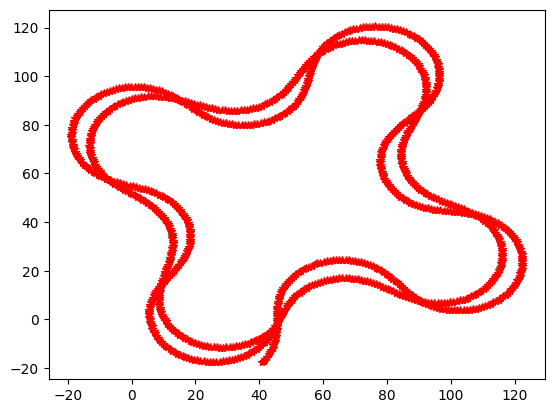

**********************************************************************************

Final parameters:  [0.08999999999999989, 0.0, 0.0]

Error:  217934.60353585114


In [2]:
radius = 50.0
params,err = twiddle(radius,dkp=1.0,dkd=0,dki=0)
err = run(params, radius,True)

**Task 1.2:** 

2) PI controller, with 𝐾𝑑=0;


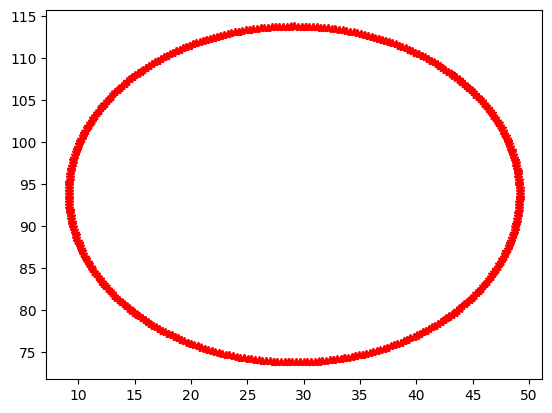

**********************************************************************************

Final parameters:  [0.08999999999999987, 0.0, 0.6561]

Error:  193772.89849760587


In [3]:
radius = 50.0
params,err = twiddle(radius,dkp=1.0,dkd=0,dki=1.0)
err = run(params, radius,True)

**Task 1.3:** 

3) PD controller, with 𝐾𝑖=0;


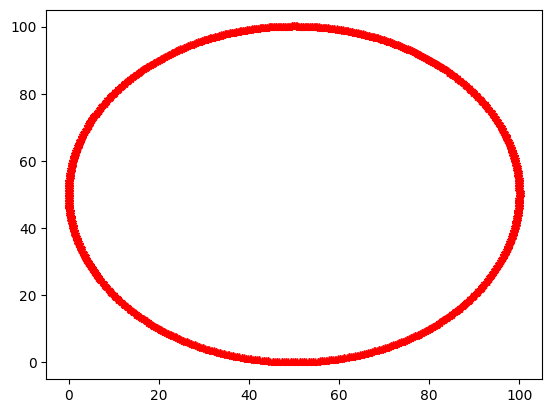

**********************************************************************************

Final parameters:  [7.715069121541531, 5.541200569117848, 0.0]

Error:  2.4281008015418672


In [4]:
radius = 50.0
params,err = twiddle(radius,dkp=1.0,dkd=1.0,dki=0.0)
err = run(params, radius,True)

**Task 1.4:** 

4) PID controller.

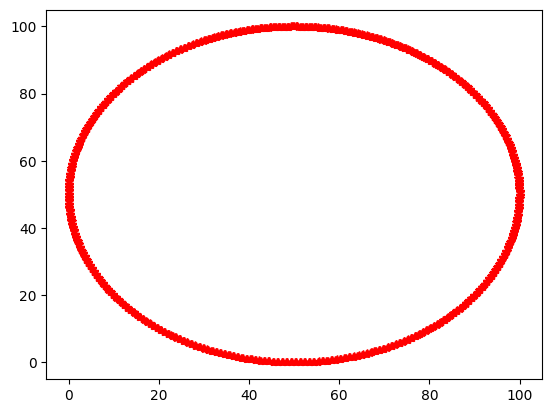

**********************************************************************************

Final parameters:  [1.179507237017131, 15.084940496716309, 0.07151489999999991]

Error:  6.098841430444686e-26


In [5]:
radius = 50.0
params,err = twiddle(radius,dkp=1.0,dkd=1.0,dki=1.0)
err = run(params, radius,True)

**Task 2:** 

For PID controller with increased speed 10.0, and for 

(a) timestep1.0, (b) your final dt that achieves low tracking error:

1. The final controller PID gains and average error.
2. Visualization of actual trajectoryfor the last N timesteps.
3. Python programs named “PIDControl Racetrack-TS1-YourLastName.py”, “PIDControl Racetrack-TSdt-YourLastName.py”

**(a) timestep1.0**

In [6]:
from math import *
import random
import matplotlib.pyplot as plt

class robot:

    def __init__(self, length = 20.0):
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, new_x, new_y, new_orientation):
        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation) % (2.0 * pi)

    def set_noise(self, new_s_noise, new_d_noise):
        self.steering_noise = float(new_s_noise)
        self.distance_noise = float(new_d_noise)

    def set_steering_drift(self, drift):
        self.steering_drift = drift
        
    def move(self, steering, distance, 
             tolerance = 0.001, max_steering_angle = pi / 4.0):

        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        res = robot()
        res.length         = self.length
        res.steering_noise = self.steering_noise
        res.distance_noise = self.distance_noise
        res.steering_drift = self.steering_drift

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = tan(steering2) * distance2 / res.length

        if abs(turn) < tolerance:

            # approximate by straight line motion

            res.x = self.x + (distance2 * cos(self.orientation))
            res.y = self.y + (distance2 * sin(self.orientation))
            res.orientation = (self.orientation + turn) % (2.0 * pi)

        else:

            # approximate bicycle model for motion

            radius = distance2 / turn
            cx = self.x - (sin(self.orientation) * radius)
            cy = self.y + (cos(self.orientation) * radius)
            res.orientation = (self.orientation + turn) % (2.0 * pi)
            res.x = cx + (sin(res.orientation) * radius)
            res.y = cy - (cos(res.orientation) * radius)

        return res

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]'  % (self.x, self.y, self.orientation)
   
    def cte(self, radius):#Refer to L6 Control, p 28. 
        center = [radius, radius] 
        cte = ((self.x - center[1])**2 + (self.y - center[0])**2)**0.5 - radius
        return cte

def run(params, radius, printflag = False):
    myrobot = robot()
    myrobot.set(0.0, radius, pi / 2.0)
    speed = 10.0 # motion distance is equal to speed (we assume time = 1)
    err = 0.0
    int_crosstrack_error = 0.0
    N =1000
    crosstrack_error = myrobot.cte(radius)
    x_trajectory = []
    y_trajectory = []
    for i in range(N*2):
        diff_crosstrack_error = - crosstrack_error
        crosstrack_error = myrobot.cte(radius)
        diff_crosstrack_error += crosstrack_error
        int_crosstrack_error += crosstrack_error
        steer = -params[0] * crosstrack_error - params[1] * diff_crosstrack_error - params[2] * int_crosstrack_error
        myrobot = myrobot.move(steer, speed)

        if i >= N:
            err += crosstrack_error ** 2
            x_trajectory.append(myrobot.x)
            y_trajectory.append(myrobot.y)
        # if printflag:
            # print (myrobot)
    if printflag:
        plt.plot(x_trajectory,y_trajectory, color="r", linestyle="--", marker="*", linewidth=1.0)
        plt.show()
        print('**********************************************************************************')
        print('\nFinal parameters: ', params)
        print('\nError: ', err)
    return err / float(N)

def twiddle(radius,tol=0.2,dkp=1.0, dkd=1.0,dki=1.0):
    p = [0.9, 0.0, 0.0]
    dp = [dkp, dkd, dki]
    best_err = run(p, radius)
    it = 0
    while sum(dp) > tol:
        for i in range(len(p)):
            p[i] += dp[i]
            err = run(p, radius)
            if err < best_err:
                best_err = err
                dp[i] *= 1.1
            else:
                p[i] -= 2 * dp[i]
                err = run(p, radius)
                if err < best_err:
                    best_err = err
                    dp[i] *= 1.1
                else:
                    p[i] += dp[i]
                    dp[i] *= 0.9
        it += 1
    return p, best_err

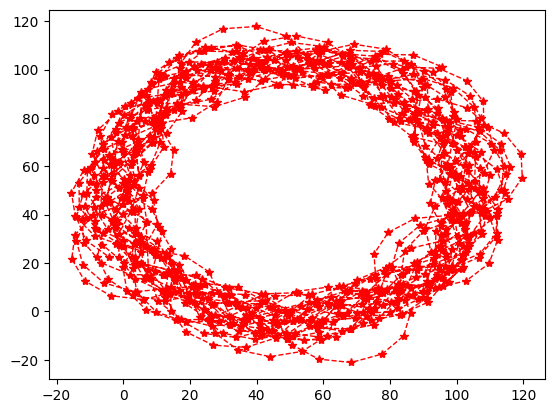

**********************************************************************************

Final parameters:  [1.0389398885500727, 0.9999999999999992, 0.0]

Error:  58273.839634341944


In [7]:
radius = 50.0
params,err = twiddle(radius,dkp=1.0,dkd=1.0,dki=1.0)
err = run(params, radius,True)

**(b) your final dt that achieves low tracking error**

In [8]:
from math import *
import random
import matplotlib.pyplot as plt

class robot:

    def __init__(self, length = 20.0):
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, new_x, new_y, new_orientation):
        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation) % (2.0 * pi)

    def set_noise(self, new_s_noise, new_d_noise):
        self.steering_noise = float(new_s_noise)
        self.distance_noise = float(new_d_noise)

    def set_steering_drift(self, drift):
        self.steering_drift = drift
        
    def move(self, steering, distance, 
             tolerance = 0.001, max_steering_angle = pi / 4.0):

        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        res = robot()
        res.length         = self.length
        res.steering_noise = self.steering_noise
        res.distance_noise = self.distance_noise
        res.steering_drift = self.steering_drift

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = tan(steering2) * distance2 / res.length

        if abs(turn) < tolerance:

            # approximate by straight line motion

            res.x = self.x + (distance2 * cos(self.orientation))
            res.y = self.y + (distance2 * sin(self.orientation))
            res.orientation = (self.orientation + turn) % (2.0 * pi)

        else:

            # approximate bicycle model for motion

            radius = distance2 / turn
            cx = self.x - (sin(self.orientation) * radius)
            cy = self.y + (cos(self.orientation) * radius)
            res.orientation = (self.orientation + turn) % (2.0 * pi)
            res.x = cx + (sin(res.orientation) * radius)
            res.y = cy - (cos(res.orientation) * radius)

        return res

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]'  % (self.x, self.y, self.orientation)
   
    def cte(self, radius):
        center = [radius, radius] 
        cte = ((self.x - center[1])**2 + (self.y - center[0])**2)**0.5 - radius
        return cte

def run(params, radius, dt, printflag = False):
    myrobot = robot()
    myrobot.set(0.0, radius, pi / 2.0)
    speed = 10.0 # motion distance is equal to speed (we assume time = 1)
    err = 0.0
    int_crosstrack_error = 0.0
    N =1000
    crosstrack_error = myrobot.cte(radius)
    x_trajectory = []
    y_trajectory = []
    for i in range(N*2):
        diff_crosstrack_error = - crosstrack_error
        crosstrack_error = myrobot.cte(radius)
        diff_crosstrack_error = (diff_crosstrack_error+crosstrack_error)/dt
        int_crosstrack_error += crosstrack_error*dt
        steer = -params[0] * crosstrack_error - params[1] * diff_crosstrack_error - params[2] * int_crosstrack_error
        myrobot = myrobot.move(steer, speed*dt)

        if i >= N:
            err += crosstrack_error ** 2
            x_trajectory.append(myrobot.x)
            y_trajectory.append(myrobot.y)
    if printflag:
        plt.plot(x_trajectory,y_trajectory, color="r", linestyle="--", marker="*", linewidth=1.0)
        plt.show()
        print('**********************************************************************************')
        print('\nFinal parameters: ', params)
        print('\nError: ', err)
    return err / float(N)

def twiddle(radius,tol=0.2,dkp=1.0, dkd=1.0,dki=1.0, dt=1):
    p = [0.9, 0.0, 0.0]
    dp = [dkp, dkd, dki]
    best_err = run(p, radius, dt)
    it = 0
    while sum(dp) > tol:
        for i in range(len(p)):
            p[i] += dp[i]
            err = run(p, radius, dt)
            if err < best_err:
                best_err = err
                dp[i] *= 1.1
            else:
                p[i] -= 2 * dp[i]
                err = run(p, radius, dt)
                if err < best_err:
                    best_err = err
                    dp[i] *= 1.1
                else:
                    p[i] += dp[i]
                    dp[i] *= 0.9
        it += 1
    return p, best_err

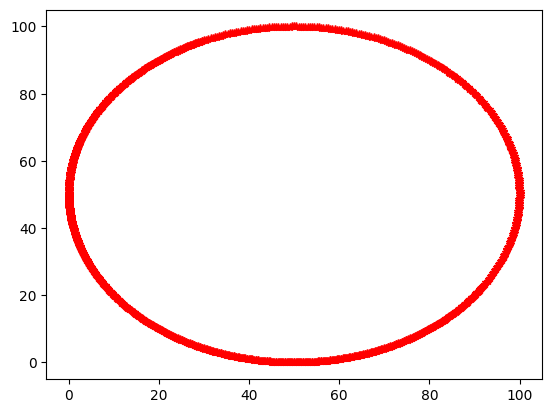

**********************************************************************************

Final parameters:  [1.7297027829370246, 1.5261265900000003, 0.6113432161000001]

Error:  4.7407384960161925e-26


In [9]:
radius = 50.0
dt=0.05
params,err = twiddle(radius,dkp=1.0,dkd=1.0,dki=1.0,dt=dt)
err = run(params, radius, dt=dt, printflag=True)